## The SIR model

The SIR model of epidemiology partitions the population into three compartments: susceptibles, S, who can catch the disease; infectives, I, who have already caught the disease and infect susceptibles; and removed individuals, R. Since the disease is assumed not to be fatal, the sum $N=S+I+R$ remains constant. The rate at which the susceptibles get infected is 
$$
\lambda(t) = \frac{\beta I}{N}
$$
where the parameter $\beta$ is the probability of infection on contact. The infected individuals remove from the disease at a rate $\gamma$. Then, the ordinary differential equations of the SIR model are

\begin{align}
\dot S &= -\lambda(t)S \\
\dot I &= \lambda(t)I - \gamma I \\
\dot R &= \gamma I 
\end{align}

This example integrates the above equations to obtain what is called the **epidemic curve**: a plot of the number of susceptibles and infectives as a function of time. 

Below we use the class `Model` to simulate SIR model with three age-groups

In [1]:
# M=3, SIR with three age-groups

import numpy as np
import pyross
import copy

import matplotlib.pyplot as plt


model_spec = { "classes" : ["S", "I"],

             "S" : {"infection" : [ ["I","S", "-beta"] ]},  ## the I class passes infection to S class
             "I" : { "linear"    : [ ["I", "-gamma"] ],     ## this is recovery process for I class
                    "infection" : [ ["I", "S", "beta"]]}    
             
              ## the recovered class R is internally determined by number conservation
             }


parameters = {'beta'  : 0.1,
              'gamma' : 0.1, 
              }

M=3;  Ni=1000*np.ones(M);  N=np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    980, 980, 980,    # S
    20,   20,  20,    # I
])

# Or initial conditions as a dictionary 
x0 = {'S': [n-20 for n in Ni], 'I':  [20, 20, 20]  }


CM = np.array( [[1,   0.5, 0.1],
               [0.5, 1,   0.5],
               [0.1, 0.5, 1  ]], dtype=float)

def contactMatrix(t):
    return CM


# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 

model = pyross.deterministic.Model(model_spec, parameters, M, Ni)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)


# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

## A toy model for vaccinations, derived from SEIR


In [2]:
model_spec = {
    "classes" : ["S", "E", "I", "R"],

    "S" : {
        "infection" : [ ["I", "S", "-beta"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["I", "S", "beta"] ]
    },
    
    "I" : {
        "linear"    : [ ["E", "gammaE"],
                        ["I", "-gammaI"]]  
    },
    
    "R" : {
        "linear"    : [ ["I", "gammaI"] ],     
    }
}


In [3]:
parameters = {
    'beta' : 0.05,
    'gammaE' : 0.5,
    'gammaI' : 0.1
}

In [4]:
M = 3                
Ni = 50000*np.ones(M)
N = np.sum(Ni) 



# initial conditions as a dictionary 
E0 = [30, 30, 30]
S0 = [n-30 for n in Ni]
I0 = [0, 0, 0]
R0 = [0, 0, 0]

x0 = {
    'S' : S0,
    'E' : E0,
    'I' : I0, 
    'R' : R0 
}

CM = np.array([
    [3,   0.8, 0.1],  # youngest cohort spreading most
    [0.8, 2,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

# the contact matrix is time-dependent
def contactMatrix(t):
    if t<40:
        xx = CM
    elif 40<=t<200:
        xx = 0.5*CM
    elif 200<=t<280:
        xx = 0.9*CM
    elif 280<=t<370:
        xx = 0.5*CM
    else:
        xx = CM
    return xx

# duration of simulation and data file
Tf = 1000;  Nf=Tf+1; 

model = pyross.deterministic.Model(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

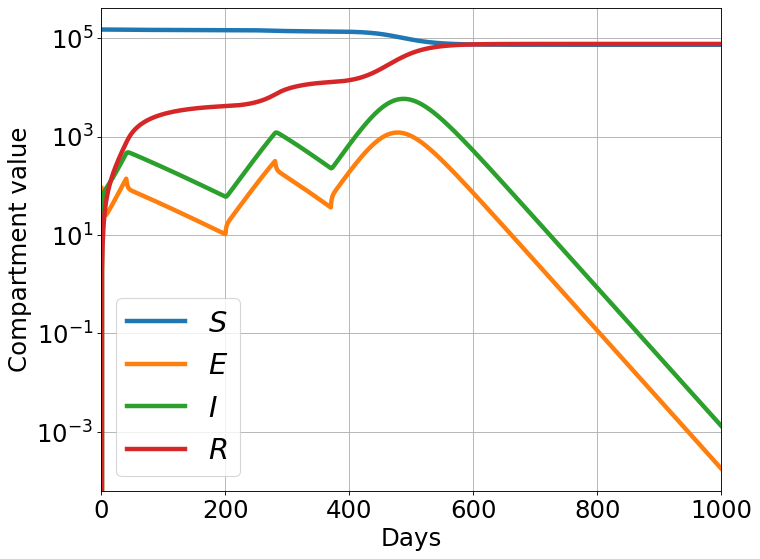

In [5]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
E = np.sum(model.model_class_data('E', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.semilogy(t, S, '-',  label='$S$', lw=4)
plt.semilogy(t, E, '-',  label='$E$', lw=4)
plt.semilogy(t, I, '-', label='$I$', lw=4)
plt.semilogy(t, R, '-',  label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

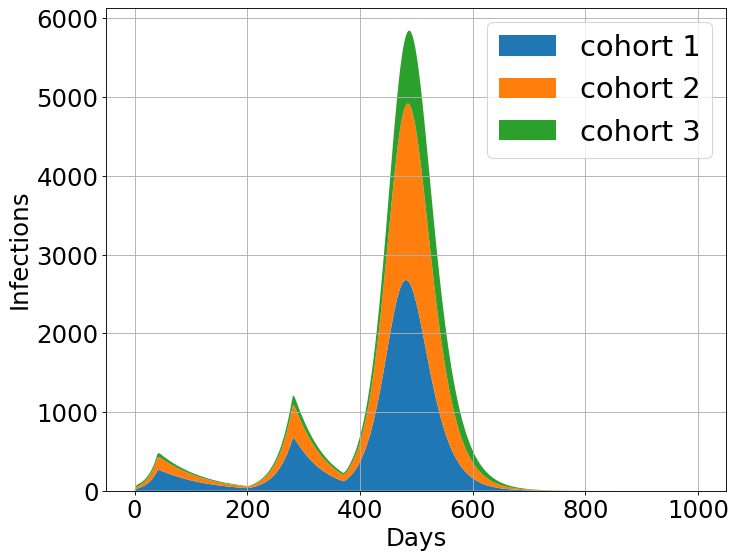

In [6]:
# age structure
Ii = model.model_class_data('I', data)

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.stackplot(t,np.transpose(Ii),labels=('cohort 1','cohort 2','cohort 3'))
plt.legend(fontsize=26); plt.grid()
plt.ylabel('Infections')
plt.xlabel('Days');

Without vaccinations, herd immunity is reached after the 3rd wave (no further lockdown). Total number of people that had been infected, by age group:

In [7]:
np.round(np.sum(Ii,axis=0)*parameters['gammaI'])

array([34921., 28938., 12600.])

### The SEIR model with vaccinations

This code takes the `Model` specification of SEIR, extends the number of classes by the vaccinated version of classes and sets up all the transitions. There are additional infection terms, the linear terms are the same in the vaccinated compartments (though they might be changed later, to account for a reduction in severity), and finite resource terms move individuals from the unvaccinated to the vaccinated classes. 

This avoids typing the whole model specification by hand, and should also work for our more detailed, calibrated models.

The vaccinated version of class X is labeled XV, The extension to different types/doses of vaccinations should be straightforward (XV1, XV2, et.c).

In [8]:
model_spec_vaccinations = copy.deepcopy(model_spec)

for cl in model_spec["classes"]:
    clV = cl+'V'
    model_spec_vaccinations["classes"].append(clV)
    
    model_spec_vaccinations[clV] = {}
    if "infection" in model_spec[cl]:
        model_spec_vaccinations[clV]["infection"] = []
        for term in model_spec[cl]["infection"]:
            
            termI = term.copy() # vaccinated infecting unvaccinated
            termI[0] += 'V'
            termI[2] += "*thetaI"
            model_spec_vaccinations[cl]["infection"].append(termI)
            
            termS = term.copy() # unvaccinated infecting vaccinated
            termS[1] += 'V'
            termS[2] += "*thetaS"
            model_spec_vaccinations[clV]["infection"].append(termS)
            
            termSI = term.copy() # vaccinated infecting vaccinated
            termSI[0] += 'V'
            termSI[1] += 'V'
            termSI[2] += "*thetaS*thetaI"
            model_spec_vaccinations[clV]["infection"].append(termSI)
            
    if "linear" in model_spec[cl]:
        model_spec_vaccinations[clV]["linear"] = []
        for term in model_spec[cl]["linear"]:
            termV = term.copy()
            termV[0] += 'V'
            model_spec_vaccinations[clV]["linear"].append(termV)
    
    if "finite-resource" in model_spec[cl]:
        model_spec_vaccinations[clV]["finite-resource"] = []
        for term in model_spec[cl]["finite-resource"]:
            termV = term.copy()
            termV[0] += 'V'
            model_spec_vaccinations[clV]["finite-resource"].append(termV)
    else:
        model_spec_vaccinations[cl]["finite-resource"] = []
        model_spec_vaccinations[clV]["finite-resource"] = []
    term = [cl, "vaccination_rate", "vaccination_priority", "one"]   # one: probability that the vaccination is successful. Set to 1, because we already 
                                                                     # account for the imperfectness of vaccinations through the theta parameters
    model_spec_vaccinations[clV]["finite-resource"].append(term.copy())
    term[1] = "-"+term[1]
    model_spec_vaccinations[cl]["finite-resource"].append(term)
    
model_spec_vaccinations


{'classes': ['S', 'E', 'I', 'R', 'SV', 'EV', 'IV', 'RV'],
 'S': {'infection': [['I', 'S', '-beta'], ['IV', 'S', '-beta*thetaI']],
  'finite-resource': [['S',
    '-vaccination_rate',
    'vaccination_priority',
    'one']]},
 'E': {'linear': [['E', '-gammaE']],
  'infection': [['I', 'S', 'beta'], ['IV', 'S', 'beta*thetaI']],
  'finite-resource': [['E',
    '-vaccination_rate',
    'vaccination_priority',
    'one']]},
 'I': {'linear': [['E', 'gammaE'], ['I', '-gammaI']],
  'finite-resource': [['I',
    '-vaccination_rate',
    'vaccination_priority',
    'one']]},
 'R': {'linear': [['I', 'gammaI']],
  'finite-resource': [['R',
    '-vaccination_rate',
    'vaccination_priority',
    'one']]},
 'SV': {'infection': [['I', 'SV', '-beta*thetaS'],
   ['IV', 'SV', '-beta*thetaS*thetaI']],
  'finite-resource': [['S',
    'vaccination_rate',
    'vaccination_priority',
    'one']]},
 'EV': {'infection': [['I', 'SV', 'beta*thetaS'],
   ['IV', 'SV', 'beta*thetaS*thetaI']],
  'linear': [['EV', '-

In [9]:
parameters = {
    'beta' : 0.05,
    'gammaE' : 0.5,
    'gammaI' : 0.1,
    'thetaS' : 0.6,  
    'thetaI' : 0.6,
}

The age-dependence of vaccinations is introduced explicitly through an age-dependent vaccination rate. 
Alternatively, one could have specified a scalar vaccination rate, and implicilty realised the age-dependence though age-dependent priorities.

In [10]:

def vaccination_rate(t):
    rate=500*np.array([0.5*np.tanh((t-420)/10)-0.5*np.tanh((t-480)/10),
                       0.5*np.tanh((t-360)/10)-0.5*np.tanh((t-420)/10),
                       0.5*np.tanh((t-300)/20)-0.5*np.tanh((t-360)/10)  ])
    rate*=(rate>1)
    return rate

def parameter_mapping(input_parameters, t):
    output_parameters = {
        'beta' : input_parameters['beta'],
        'gammaE' : input_parameters['gammaE'],
        'gammaI' : input_parameters['gammaI'],
        'beta*thetaS' : input_parameters['beta']*input_parameters['thetaS'],
        'beta*thetaI' : input_parameters['beta']*input_parameters['thetaI'],
        'beta*thetaS*thetaI' : input_parameters['beta']*input_parameters['thetaS']*input_parameters['thetaI'],
        'one' : 1,
        'vaccination_priority' : 1,
        'vaccination_rate' : vaccination_rate(t)     
    }
        
    return output_parameters

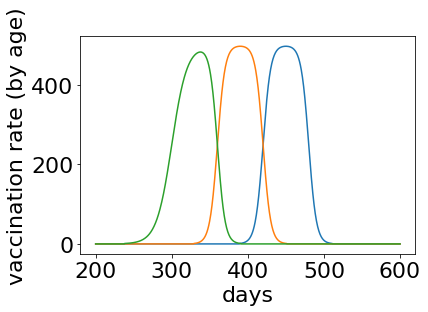

In [11]:
t=np.linspace(200,600,1024)
v=[vaccination_rate(tt) for tt in t]
plt.plot(t,v)
plt.xlabel('days')
plt.ylabel('vaccination rate (by age)')
plt.show()

In [12]:
# initial conditions as a dictionary 
E0 = [30, 30, 30]
S0 = [n-30 for n in Ni]
I0 = [0, 0, 0]
R0 = [0, 0, 0]

x0 = {
    'S' : S0,
    'E' : E0,
    'I' : I0, 
    'R' : R0 
}

for cl in model_spec["classes"]:
    x0[cl+'V'] = np.zeros(M)


# duration of simulation and data file
Tf = 1000;  Nf=Tf+1; 

model = pyross.deterministic.Model(model_spec_vaccinations, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)




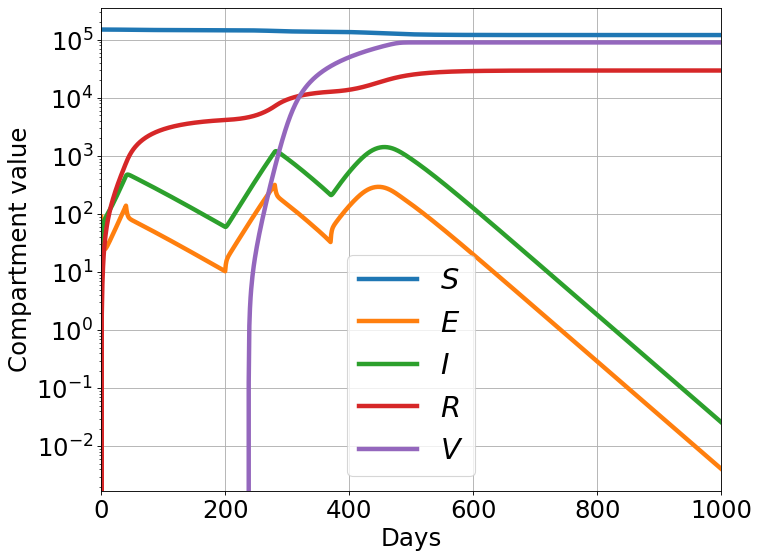

In [13]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
E = np.sum(model.model_class_data('E', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
SV = np.sum(model.model_class_data('SV', data), axis=1)
EV = np.sum(model.model_class_data('EV', data), axis=1)
IV = np.sum(model.model_class_data('IV', data), axis=1)
RV = np.sum(model.model_class_data('RV', data), axis=1)
V=SV+EV+IV+RV
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.semilogy(t, S+SV, '-',  label='$S$', lw=4)
plt.semilogy(t, E+EV, '-',  label='$E$', lw=4)
plt.semilogy(t, I+IV, '-', label='$I$', lw=4)
plt.semilogy(t, R+RV, '-',  label='$R$', lw=4)
plt.semilogy(t, V, '-',  label='$V$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

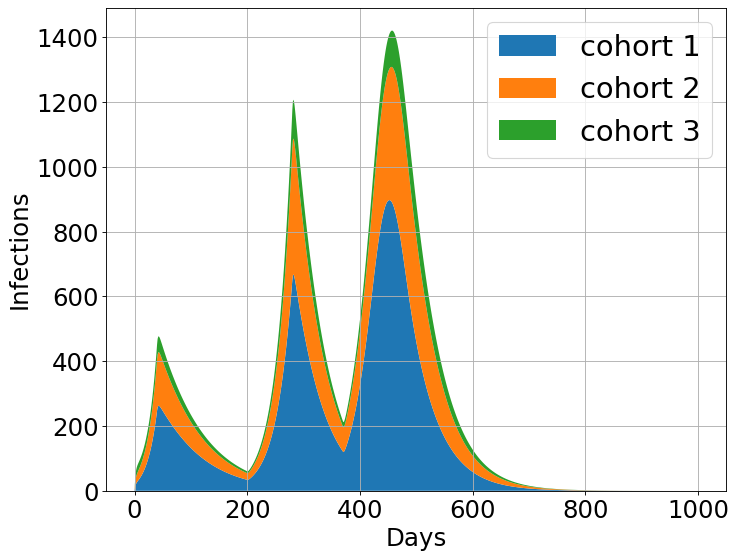

In [14]:
# age structure
Ii = model.model_class_data('I', data)
IVi = model.model_class_data('IV', data)


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.stackplot(t,np.transpose(Ii+IVi),labels=('cohort 1','cohort 2','cohort 3'))
plt.legend(fontsize=26); plt.grid()
plt.ylabel('Infections')
plt.xlabel('Days');

With vaccinations, the 3rd wave is reduced, despite the lifting of lockdown. Total number of people that had been infected, by age group:

In [15]:
# unvaccinated
np.round(np.sum(Ii,axis=0)*parameters['gammaI'])

array([13855.,  7407.,  2040.])

In [16]:
# vaccinated
np.round(np.sum(IVi,axis=0)*parameters['gammaI'])

array([2850., 2539.,  852.])